In [1]:
import math
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from tqdm import tqdm

/hpc_share/ee217092/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#ハイパラ
input_dim = 784  # 画像データxのサイズ（MNIST画像は28x28=784）
hidden_dim = 200  # ニューラルネットワークの中間層の次元数
latent_dim = 20  # 潜在変数ベクトルzの次元数
epochs = 15
learning_rate = 3e-4
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.linear_mu = nn.Linear(hidden_dim, latent_dim)
        self.linear_sigma = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, x):
        x = F.relu(self.linear(x))
        mu = self.linear_mu(x)
        sigma = self.linear_sigma(x)
        return mu, sigma

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, z):
        h = self.linear1(z)
        h = F.relu(h)
        h = self.linear2(h)
        x_hat = F.sigmoid(h)
        return x_hat

In [4]:
def reparameter(mu, sigma):
    eps = torch.randn_like(sigma)
    return mu + eps * sigma

In [5]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)
    
    def get_loss(self, x):
        #x = x.view(x.size(0), -1)
        mu, sigma = self.encoder(x)
        z = reparameter(mu, sigma)
        x_hat = self.decoder(z)

        batch_size = len(x)
        L1 = F.mse_loss(x, x_hat, reduction='sum')
        L2 = torch.sum(mu**2 + sigma**2 - torch.log(sigma**2) - 1)
        return (L1 + L2)/batch_size

In [6]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(torch.flatten) # 画像をフラットに
            ])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
#dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7]:

# ②モデルとオプティマイザ
model = VAE(input_dim, hidden_dim, latent_dim)
model=model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []

# ③学習ループ
for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    for x, label in tqdm(dataloader):
        x = x.to(device)
        optimizer.zero_grad()
        loss = model.get_loss(x)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print("epoch:",epoch," ",loss_avg)

100%|██████████| 1875/1875 [00:08<00:00, 233.54it/s]


epoch: 0   59.552944651285806


100%|██████████| 1875/1875 [00:07<00:00, 255.47it/s]


epoch: 1   46.53361084391276


100%|██████████| 1875/1875 [00:08<00:00, 208.66it/s]


epoch: 2   43.55838728230794


100%|██████████| 1875/1875 [00:08<00:00, 209.77it/s]


epoch: 3   42.20309949747721


100%|██████████| 1875/1875 [00:08<00:00, 209.55it/s]


epoch: 4   41.472672322591144


100%|██████████| 1875/1875 [00:08<00:00, 211.12it/s]


epoch: 5   40.96062716878255


100%|██████████| 1875/1875 [00:08<00:00, 223.51it/s]


epoch: 6   40.55130809936524


100%|██████████| 1875/1875 [00:08<00:00, 211.51it/s]


epoch: 7   40.26690583089193


100%|██████████| 1875/1875 [00:08<00:00, 211.85it/s]


epoch: 8   40.06689053751628


100%|██████████| 1875/1875 [00:08<00:00, 211.80it/s]


epoch: 9   39.90372656046549


100%|██████████| 1875/1875 [00:08<00:00, 212.76it/s]


epoch: 10   39.72104857381185


100%|██████████| 1875/1875 [00:08<00:00, 212.20it/s]


epoch: 11   39.58634326375326


100%|██████████| 1875/1875 [00:08<00:00, 215.03it/s]


epoch: 12   39.497597226969404


100%|██████████| 1875/1875 [00:08<00:00, 216.36it/s]


epoch: 13   39.44420557454427


100%|██████████| 1875/1875 [00:08<00:00, 216.64it/s]

epoch: 14   39.28792754007975


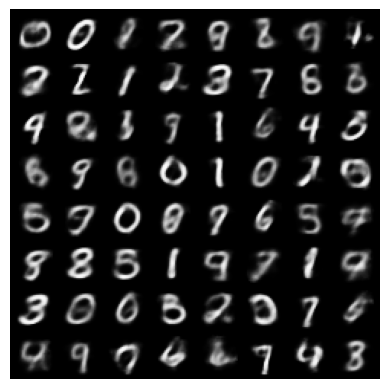

In [8]:
with torch.no_grad():  # ①
    sample_size = 64
    z = torch.randn(sample_size, latent_dim).to(device)  # ②
    x = model.decoder(z)  # ③
    generated_images = x.view(sample_size, 1, 28, 28)  # ④

# ⑤
grid_img = torchvision.utils.make_grid(generated_images, nrow=8, padding=2, normalize=True)

plt.imshow(grid_img.permute(1, 2, 0).cpu())
plt.axis("off")
plt.show()